<a href="https://colab.research.google.com/github/Superkid0714/GCA_AI-Mini-Project/blob/main/MINI_PROJECT_Model_ver1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 배열
import numpy as np

# 데이터 분석
import pandas as pd

In [ ]:
# Pandas option 정의
pd.set_option( 'display.max_columns', 20 )
pd.set_option( 'display.max_colwidth', 20 )
pd.set_option( 'display.unicode.east_asian_width', True )

In [ ]:
# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Jupyter note상에 그래프 결과 포함 매직 명령
%matplotlib inline

# Matplotlib 기본 글꼴 정의
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [ ]:
import sys

# 노트북이 코랩에서 실행 중인지 체크합니다.
if 'google.colab' in sys.modules:
    !echo 'debconf debconf/frontend select Noninteractive' | debconf-set-selections

    # 나눔 폰트를 설치합니다.
    !sudo apt-get -qq -y install fonts-nanum
    import matplotlib.font_manager as fm
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

#     # 나눔바른고딕 폰트로 설정합니다.
    import matplotlib.pyplot as plt
    plt.rc('font', family='NanumBarunGothic')

#     # 마이너스 기호 표시 오류 수정
    import matplotlib
    matplotlib.rcParams['axes.unicode_minus'] = False

Selecting previously unselected package fonts-nanum.
(Reading database ... 123586 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [ ]:
# 경고 문제 출력 제한
import warnings

warnings.filterwarnings( 'ignore' )

In [ ]:
# Tensorflow
import tensorflow as tf

tf.__version__

'2.15.0'

In [ ]:
# Tensorflow Sequential model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Concatenate,LSTM
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization
from tensorflow.keras import optimizers

from tensorflow.keras.utils import plot_model

In [ ]:
# 데이터 분리를 위한 함수
from sklearn.model_selection import train_test_split


In [ ]:
def disp_training( history ):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range( 1, len( accuracy ) + 1 )

    plt.title( '훈련 및 검증 정확도' )
    plt.plot( epochs, history.history[ 'accuracy' ], label = 'accuracy' )
    plt.plot( epochs, history.history[ 'val_accuracy' ], label = 'val_accuracy' )
    plt.grid()
    plt.legend()
    plt.xlabel( 'Epochs' )

    plt.figure()
    plt.title( '훈련 및 검증 오차' )

    plt.plot( epochs, history.history[ 'loss' ], label = 'loss' )
    plt.plot( epochs, history.history[ 'val_loss' ], label = 'val_loss' )
    plt.grid()
    plt.legend()
    plt.xlabel( 'Epochs' )

    plt.show()

In [ ]:
def disp_loss( history ):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range( 1, len( loss ) + 1 )

    plt.title( '훈련 및 검증 오차' )

    plt.plot( epochs, history.history[ 'loss' ], label = 'loss' )
    plt.plot( epochs, history.history[ 'val_loss' ], label = 'val_loss' )
    plt.grid()
    plt.legend()
    plt.xlabel( 'Epochs' )

    plt.show()

# 모델 제작


In [ ]:
from sklearn.preprocessing import MinMaxScaler # MinMaxScaler는 입력 데이터를 0과 1 사이의 범위로 변환


### 데이터 가져오기




In [ ]:
# 데이터 로드
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
submission_df = pd.read_csv('sample_submission.csv')

### 전처리 시작!!

In [ ]:
# 날짜 형식 변환 및 정렬
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])
train_df = train_df.sort_values(by='timestamp') # LSTM 모델을 쓸건데 시간순서대로 있으면 잘 학습함 그래서 정렬
test_df = test_df.sort_values(by='timestamp')

In [ ]:
# 결측치 처리
train_df = train_df.dropna(subset=['supply(kg)', 'price(원/kg)'])  #dropna는 pandas에서 제공하는 결측치 제거 함수

In [ ]:
# 공급량이 0인 행 제거
train_df = train_df[train_df['supply(kg)'] > 0]

In [ ]:
# 필요 없는 열 제거 (ID 열 제거)
train_df = train_df.drop(columns=['ID'])
test_df = test_df.drop(columns=['ID'])

In [ ]:
# 시간 관련 피쳐 생성 (모델이 시간에 따른 주기적 패턴을 학습할 수 있도록)
train_df['month'] = train_df['timestamp'].dt.month
train_df['day'] = train_df['timestamp'].dt.day
train_df['day_of_week'] = train_df['timestamp'].dt.dayofweek

test_df['month'] = test_df['timestamp'].dt.month
test_df['day'] = test_df['timestamp'].dt.day
test_df['day_of_week'] = test_df['timestamp'].dt.dayofweek

In [ ]:
# 범주형 데이터 인코딩
train_df = pd.get_dummies(train_df, columns=['item', 'corporation', 'location'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['item', 'corporation', 'location'], drop_first=True)

In [ ]:
# train_df와 test_df의 열 맞추기
missing_cols = set(train_df.columns) - set(test_df.columns)
for c in missing_cols:
    test_df[c] = 0
test_df = test_df[train_df.columns.drop('price(원/kg)')]

In [ ]:
from sklearn.preprocessing import StandardScaler

# 스케일링
scaler_s = StandardScaler()
scaler_p = StandardScaler()
train_df['supply(kg)'] = scaler_s.fit_transform(train_df[['supply(kg)']])
train_df['price(원/kg)'] = scaler_p.fit_transform(train_df[['price(원/kg)']])

In [ ]:
# 훈련 데이터와 테스트 데이터 분할 (시계열 데이터에서는 시간순서가 매우 중요하기에 해당 조건을 걸어둠)
train_data = train_df[train_df['timestamp'] < '2023-03-04']
test_data = test_df[test_df['timestamp'] >= '2023-03-04']

In [ ]:
# 특성과 타겟 분리
X_train = train_data.drop(['timestamp', 'price(원/kg)'], axis=1).values
y_train = train_data['price(원/kg)'].values

X_test = test_data.drop(['timestamp'], axis=1).values

In [ ]:
# 데이터 타입 변환
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
X_test = X_test.astype(np.float32)

In [ ]:
# 데이터 reshape (LSTM모델을 쓸건데 LSTM모델은 3차원만 입력받아요)
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### 모델링!!!

In [ ]:
# LSTM 모델 구축
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(1))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 14, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 14, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 14, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 14, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 14, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error',metrics = ['mean_absolute_error'])

In [ ]:
# 모델 학습
history =model.fit(X_train_reshaped, y_train, batch_size=32, epochs=50)

Epoch 1/50
749/749 [==============================] - 19s 12ms/step - loss: 0.8987 - mean_absolute_error: 0.7477
Epoch 2/50
749/749 [==============================] - 9s 12ms/step - loss: 0.2809 - mean_absolute_error: 0.3774
Epoch 3/50
749/749 [==============================] - 11s 14ms/step - loss: 0.2194 - mean_absolute_error: 0.3260
Epoch 4/50
749/749 [==============================] - 9s 12ms/step - loss: 0.2028 - mean_absolute_error: 0.3105
Epoch 5/50
749/749 [==============================] - 8s 11ms/step - loss: 0.1929 - mean_absolute_error: 0.3007
Epoch 6/50
749/749 [==============================] - 9s 12ms/step - loss: 0.1835 - mean_absolute_error: 0.2926
Epoch 7/50
749/749 [==============================] - 10s 14ms/step - loss: 0.1806 - mean_absolute_error: 0.2895
Epoch 8/50
749/749 [==============================] - 8s 11ms/step - loss: 0.1747 - mean_absolute_error: 0.2833
Epoch 9/50
749/749 [==============================] - 9s 12ms/step - loss: 0.1687 - mean_absolute_err

### 평가하자

In [ ]:
# 훈련 과정 중의 MSE 값 확인
train_mse = history.history['loss']
train_mae = history.history['mean_absolute_error']

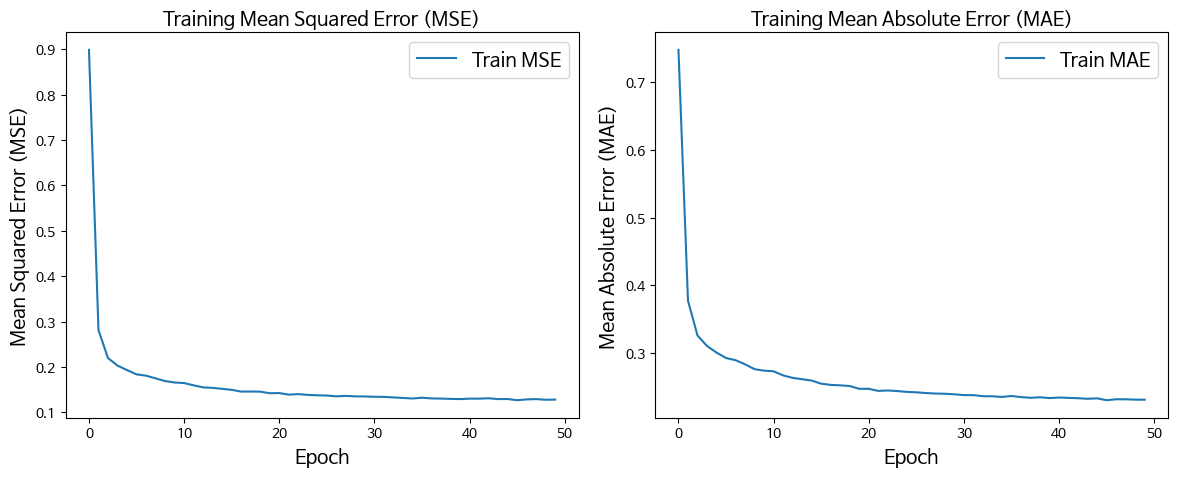

In [ ]:
# 시각화
plt.figure(figsize=(12, 5))

# MSE 시각화
plt.subplot(1, 2, 1)
plt.plot(train_mse, label='Train MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Training Mean Squared Error (MSE)')
plt.legend()

# MAE 시각화
plt.subplot(1, 2, 2)
plt.plot(train_mae, label='Train MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Training Mean Absolute Error (MAE)')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# 마지막 에포크의 MSE 값 출력
print("Final Mean Squared Error (MSE):", train_mse[-1])
print("Final Mean Absolute Error (MAE):", train_mae[-1])

Final Mean Squared Error (MSE): 0.1279664933681488
Final Mean Absolute Error (MAE): 0.23106570541858673


In [ ]:
# 평가 함수 사용
mse, mae = model.evaluate(X_train_reshaped, y_train)
print("Mean Squared Error (MSE) on training data:", mse)
print("Mean Absolute Error (MAE) on training data:", mae)


749/749 [==============================] - 6s 6ms/step - loss: 0.1229 - mean_absolute_error: 0.2350
Mean Squared Error (MSE) on training data: 0.12285276502370834
Mean Absolute Error (MAE) on training data: 0.23496101796627045


In [ ]:
# 예측
predictions = model.predict(X_test_reshaped)


35/35 [==============================] - 2s 4ms/step


In [ ]:
# 예측 값 역변환 (inverse_transform)
predictions = scaler_p.inverse_transform(predictions)

In [ ]:
# 예측 결과 저장
submission_df['answer'] = predictions
submission_df.to_csv('submission.csv', index=False)

In [ ]:
# 저장된 파일 읽기
submission_df = pd.read_csv('submission.csv')

In [ ]:
from google.colab import files

# 파일 다운로드
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>